In [1]:
import sys

sys.path.append("ml-tools-direct-method")

In [2]:
from tools.bandit import generate_bandit_feedback
from tools.estimate import get_estimator_stats, get_value_estimators
from tools.policy import ModelPolicy, UniformPolicy
from tools.utils import datasets, get_bandit, split_data

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import default_rng
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_palette("colorblind")
colors = sns.color_palette()
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["axes.titlesize"] = 14

X_MED = 10
Y_MED = 6
XY_MED = (X_MED, Y_MED)

## Experiments with Small Public Datasets 

In [ ]:
frames = {}
for data in datasets:

    if data in [
        "satimage",
        "vehicle",
        "pendigits"
    ]:  # skip these for now, I don't expect them to converge in a linear model.
        continue

    # configure dataset into bandit setting
    print("\n Fetching dataset:", data)
    contexts, full_rewards, best_actions = get_bandit(data)
    n, k = full_rewards.shape
    _, d = contexts.shape
    print(
        f"This dataset has {k} actions, the context space has {d} dimensions, and there are {n} examples."
    )

    # split train test sets
    X_train, y_train, X_test, y_test, full_rewards_test = split_data(
        contexts, full_rewards, best_actions
    )

    # create target policy using logreg
    model = LogisticRegression(multi_class="multinomial", max_iter=10000)
    model.fit(X_train, y_train)
    target_policy = ModelPolicy(model=model, num_actions=k)

    # get true value of target policy -> treated as ground truth for comparing estimates
    target_policy_true_value = target_policy.get_value_estimate(
        X_test, full_rewards_test
    )

    # create logging policy
    logging_policy = UniformPolicy(num_actions=k)

    # run 500 simulations
    trials = 500
    val_ests = []
    policy = target_policy
    policy_true_value = policy.get_value_estimate(X_test, full_rewards_test)
    rng = default_rng(6)
    for i in tqdm(range(trials)):
        contexts, actions, rewards, propensities = generate_bandit_feedback(
            X_test, full_rewards_test, logging_policy, rng=rng
        )
        est = get_value_estimators(
            policy, contexts, actions, rewards, propensities, skip_nonlin=False
        )
        val_ests.append(est)

    df = pd.DataFrame(val_ests)
    print(f"Target policy true value {target_policy_true_value}.")
    df_stats = get_estimator_stats(df, true_parameter_value=policy_true_value)
    df_stats["true"] = policy_true_value
    print(df_stats)

    frames[data] = df_stats

In [32]:
frames

{'ecoli':     stat      mean        SD       var        SE      bias      RMSE      true
 0     iw  0.557311  0.122078  0.014903  0.005459  0.003287  0.122122  0.560598
 1     dm  0.507700  0.053138  0.002824  0.002376  0.052898  0.074979  0.560598
 2  dm_iw  0.560066  0.052523  0.002759  0.002349  0.000531  0.052526  0.560598
 3     dr  0.552579  0.052374  0.002743  0.002342  0.008019  0.052985  0.560598
 4  dm_rf  0.464950  0.064702  0.004186  0.002894  0.095648  0.115477  0.560598
 5  dr_rf  0.491668  0.057179  0.003269  0.002557  0.068930  0.089559  0.560598,
 'glass':     stat      mean        SD       var        SE      bias      RMSE      true
 0     iw  0.465991  0.115304  0.013295  0.005157  0.010968  0.115825  0.455023
 1     dm  0.420011  0.088946  0.007911  0.003978  0.035012  0.095588  0.455023
 2  dm_iw  0.451191  0.106010  0.011238  0.004741  0.003833  0.106079  0.455023
 3     dr  0.447316  0.092730  0.008599  0.004147  0.007708  0.093050  0.455023
 4  dm_rf  0.301096  

In [25]:
#save estimator dfs for each dataset (so we don't need to re-run)
for frame in frames:
    frames[frame].to_csv(frame+'.csv')

In [37]:
#only load in datasets used
datasets = ['ecoli','glass','letter-recognition','optdigits','yeast']

frames = {}
for data in datasets:
    frames[data] = pd.read_csv(data+'.csv')

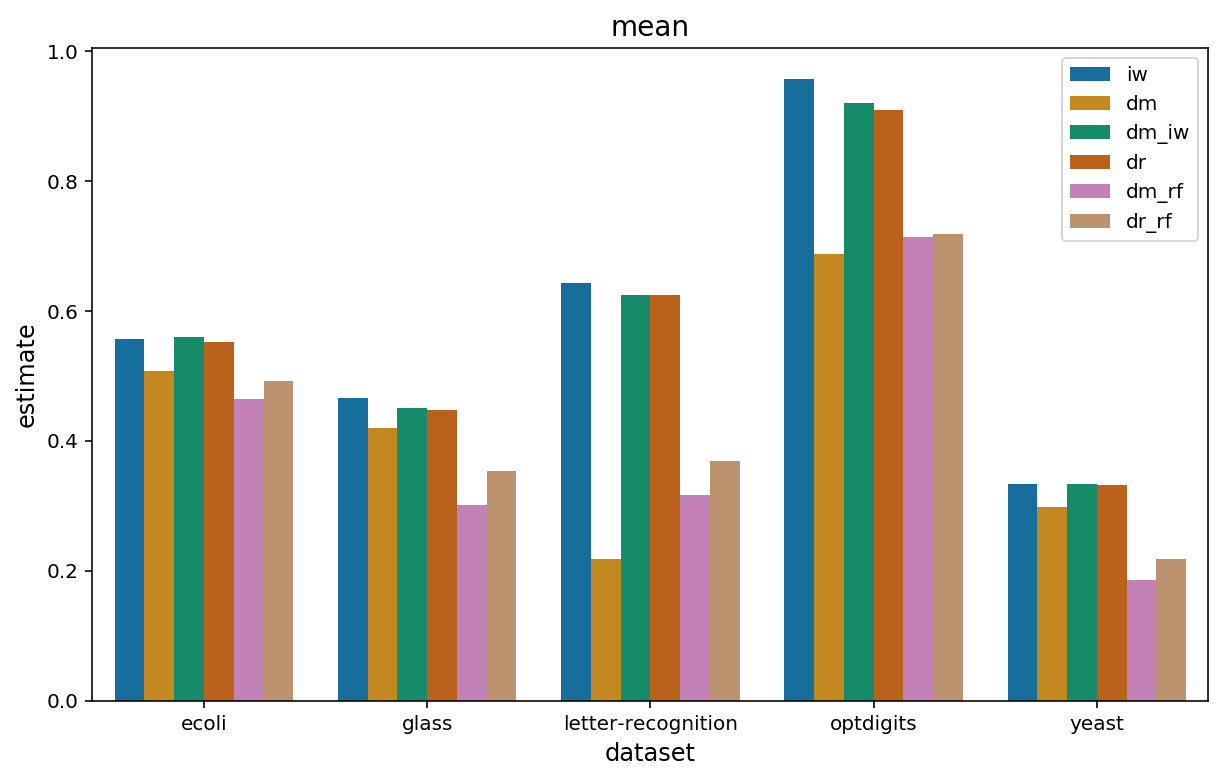

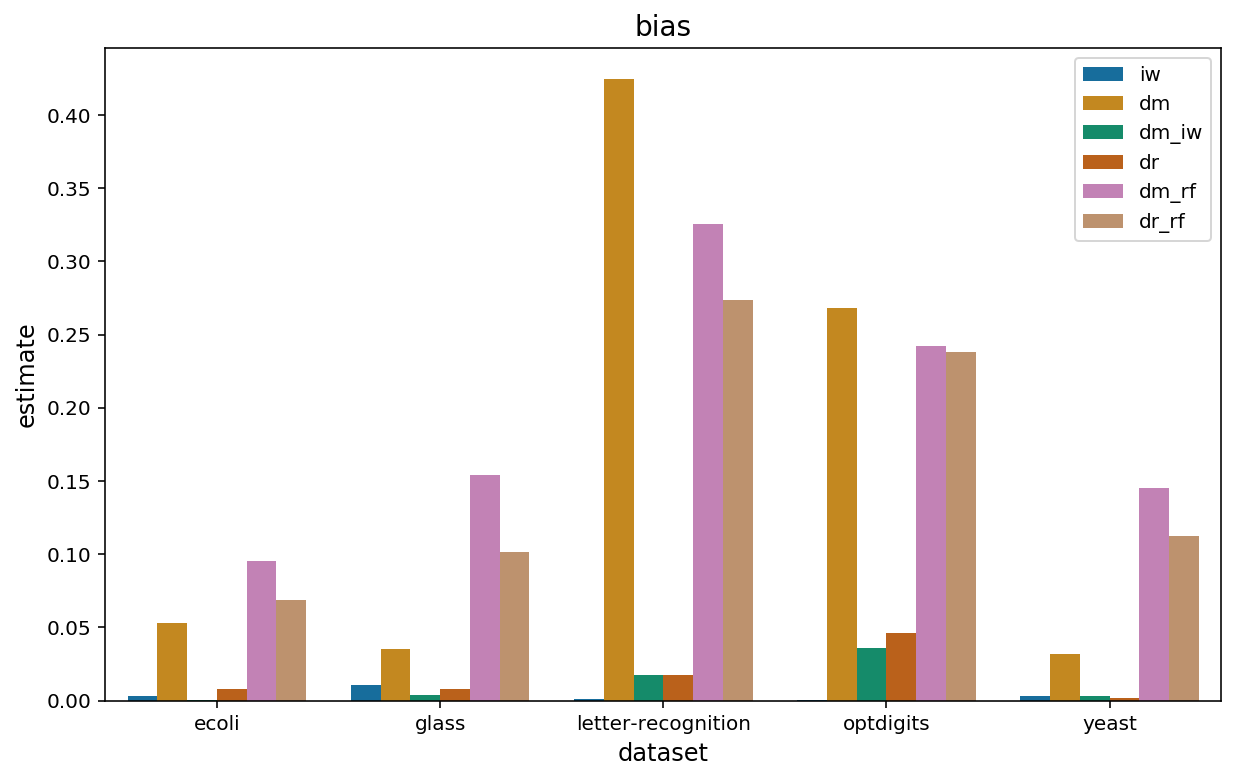

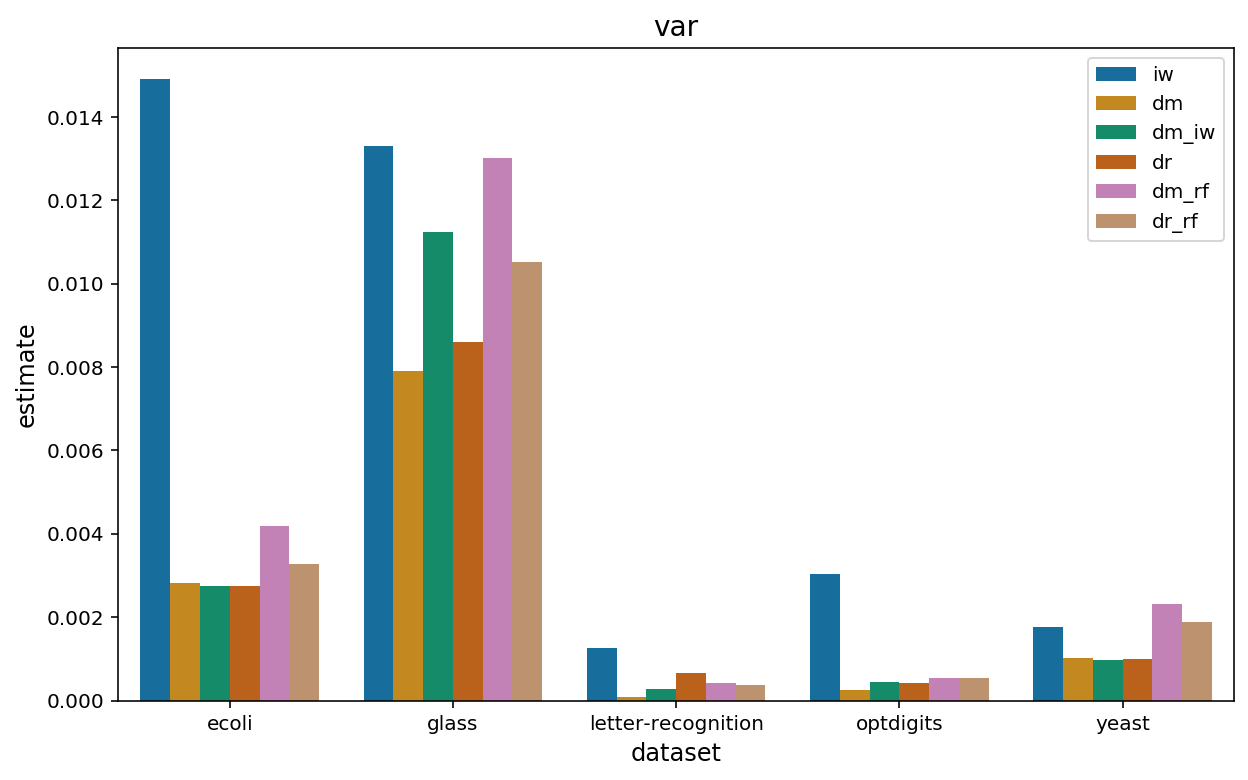

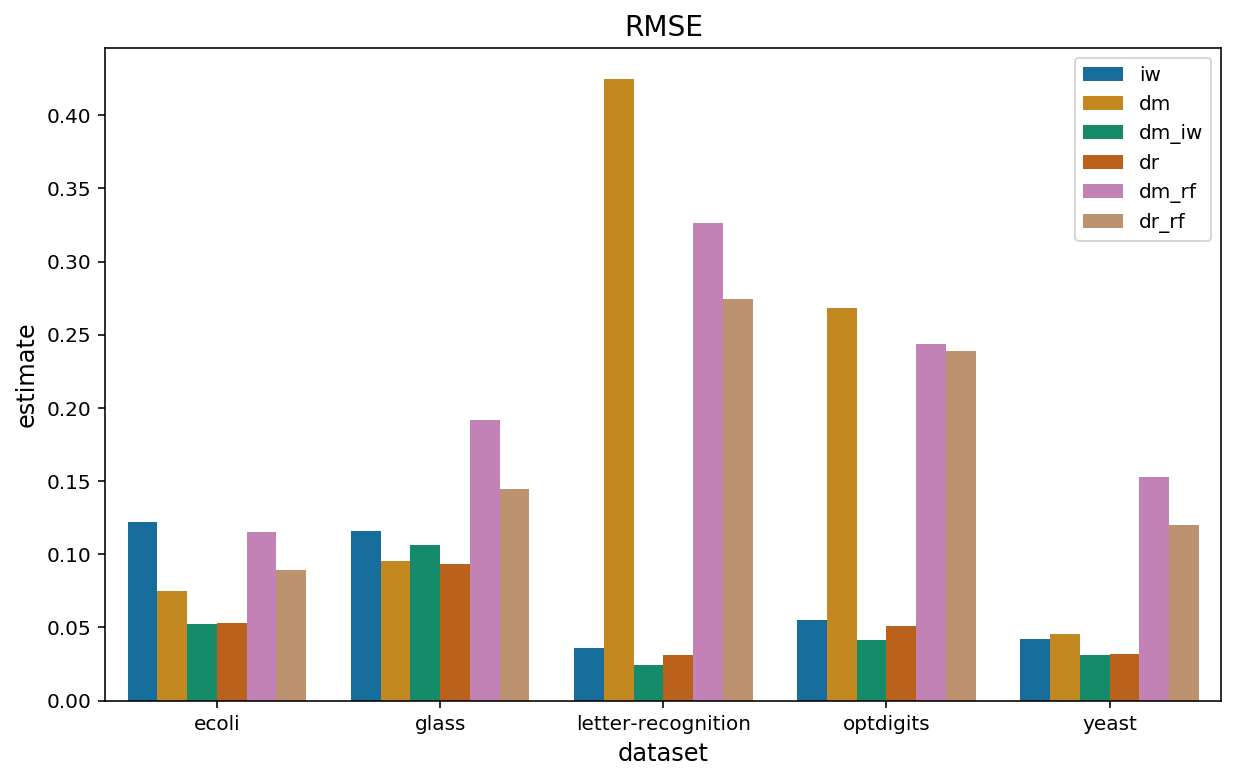

In [38]:
#visualize estimator stats for each dataset

stats = ["mean", "bias", "var", "RMSE"]
skip_nonlin = False
for stat in stats:
    iw = []
    dm = []
    dm_iw = []
    dr = []
    dm_rf = []
    dr_rf = []
    for data in datasets:

        iw.append(abs(frames[data][stat][0]))
        dm.append(abs(frames[data][stat][1]))
        dm_iw.append(abs(frames[data][stat][2]))
        dr.append(abs(frames[data][stat][3]))

        if not skip_nonlin:
            dm_rf.append(abs(frames[data][stat][4]))
            dr_rf.append(abs(frames[data][stat][5]))

    if skip_nonlin:
        df = pd.DataFrame(
            np.c_[iw, dm, dm_iw, dr], index=datasets, columns=["iw", "dm", "dm_iw", "dr"]
        )
        df = (
            df.reset_index()
            .rename({"index": "dataset"}, axis=1)
            .melt(id_vars=["dataset"], var_name="estimator", value_name="estimate")
        )
    else:
        df = pd.DataFrame(
            np.c_[iw, dm, dm_iw, dr, dm_rf, dr_rf], index=datasets, columns=["iw", "dm", "dm_iw", "dr", "dm_rf", "dr_rf"]
        )
        df = (
            df.reset_index()
            .rename({"index": "dataset"}, axis=1)
            .melt(id_vars=["dataset"], var_name="estimator", value_name="estimate")
        )
        
    fig, ax = plt.subplots(figsize=XY_MED)
    sns.barplot(data=df, x="dataset", y="estimate", hue="estimator", ax=ax)
    ax.legend()
    ax.set_title(stat)
    ax.tick_params(axis="x", labelrotation=0)